# Set up

In [3]:
from footbot.data import utils
import pandas as pd
import patsy
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/tom/footbot/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 1000)

# Getting data

In [5]:
client = utils.set_up_bigquery(secrets_path='../secrets/service_account.json')

In [9]:
sql = \
'''
SELECT
  event,
  element,
  total_points,
  safe_web_name,
  element_type,
  cluster,
  team,
  value,
  total_points_per_minute_previous_season,
  goals_scored_per_minute_previous_season,
  assists_per_minute_previous_season,
  clean_sheets_per_minute_previous_season,
  goals_conceded_per_minute_previous_season,
  own_goals_per_minute_previous_season,
  penalties_saved_per_minute_previous_season,
  penalties_missed_per_minute_previous_season,
  yellow_cards_per_minute_previous_season,
  red_cards_per_minute_previous_season,
  saves_per_minute_previous_season,
  bonus_per_minute_previous_season,
  bps_per_minute_previous_season,
  opponent_team,
  was_home,
  was_sunday,
  was_weekday,
  was_late,
  was_early,
  rolling_avg_total_points_element,
  rolling_avg_minutes_element,
  rolling_avg_goals_scored_element,
  rolling_avg_assists_element,
  rolling_avg_clean_sheets_element,
  rolling_avg_goals_conceded_element,
  rolling_avg_own_goals_element,
  rolling_avg_penalties_saved_element,
  rolling_avg_penalties_missed_element,
  rolling_avg_yellow_cards_element,
  rolling_avg_red_cards_element,
  rolling_avg_saves_element,
  rolling_avg_bonus_element,
  rolling_avg_bps_element,
  rolling_avg_total_points_element_p1,
  rolling_avg_total_points_element_p2,
  rolling_avg_total_points_element_p3,
  rolling_avg_total_points_element_p4,
  rolling_avg_total_points_element_p5,
  rolling_avg_total_points_element_p10,
  rolling_avg_goals_scored_element_p1,
  rolling_avg_goals_scored_element_p2,
  rolling_avg_goals_scored_element_p3,
  rolling_avg_goals_scored_element_p4,
  rolling_avg_goals_scored_element_p5,
  rolling_avg_goals_scored_element_p10,
  rolling_avg_assists_element_p1,
  rolling_avg_assists_element_p2,
  rolling_avg_assists_element_p3,
  rolling_avg_assists_element_p4,
  rolling_avg_assists_element_p5,
  rolling_avg_assists_element_p10,
  rolling_avg_clean_sheets_element_p1,
  rolling_avg_clean_sheets_element_p2,
  rolling_avg_clean_sheets_element_p3,
  rolling_avg_clean_sheets_element_p4,
  rolling_avg_clean_sheets_element_p5,
  rolling_avg_clean_sheets_element_p10,
  rolling_avg_goals_conceded_element_p1,
  rolling_avg_goals_conceded_element_p2,
  rolling_avg_goals_conceded_element_p3,
  rolling_avg_goals_conceded_element_p4,
  rolling_avg_goals_conceded_element_p5,
  rolling_avg_goals_conceded_element_p10,
  rolling_avg_saves_element_p1,
  rolling_avg_saves_element_p2,
  rolling_avg_saves_element_p3,
  rolling_avg_saves_element_p4,
  rolling_avg_saves_element_p5,
  rolling_avg_saves_element_p10,
  rolling_avg_minutes_element_p1,
  rolling_avg_minutes_element_p2,
  rolling_avg_minutes_element_p3,
  rolling_avg_minutes_element_p4,
  rolling_avg_minutes_element_p5,
  rolling_avg_minutes_element_p10,
  expected_total_points_against_opponent_team_element_type,
  expected_minutes_against_opponent_team_element_type,
  expected_goals_scored_against_opponent_team_element_type,
  expected_assists_against_opponent_team_element_type,
  expected_clean_sheets_against_opponent_team_element_type,
  expected_goals_conceded_against_opponent_team_element_type,
  expected_own_goals_against_opponent_team_element_type,
  expected_penalties_saved_against_opponent_team_element_type,
  expected_penalties_missed_against_opponent_team_element_type,
  expected_yellow_cards_against_opponent_team_element_type,
  expected_red_cards_against_opponent_team_element_type,
  expected_saves_against_opponent_team_element_type,
  expected_bonus_against_opponent_team_element_type,
  expected_bps_against_opponent_team_element_type,
  rolling_avg_squad,
  rolling_avg_first_team,
  rolling_avg_vice_or_captain,
  rolling_avg_squad_p1,
  rolling_avg_first_team_p1,
  rolling_avg_vice_or_captain_p1
FROM
  `footbot-001.fpl.element_gameweeks_features_1819_v01`
'''

In [10]:
# get dataframe
df_all = client.query(sql).to_dataframe()

In [11]:
last_train_event = 25
last_test_event = 38
element_filter_field = 'rolling_avg_total_points_element'
element_filter_value = 2

In [12]:
# filter out elements
element_filter_df = df_all[df_all['event'] == last_train_event + 1]

element_filter = element_filter_df[
    element_filter_df[element_filter_field] > element_filter_value
]['element'].values

df = df_all[
    (df_all['event'] <= last_test_event)
    & (df_all['element'].isin(element_filter))
]

# impute missing values by element type
df = pd.concat([
    df[df['element_type'] == i].fillna(
        df[
            (df['event'] <= last_train_event)
            & (df['element_type'] == i)
        ].mean()).fillna(0)
    for i in range(1, 5)
])

In [13]:
df = df[df['element_type'] != 1]

# Modelling data

## Splitting data

In [14]:
test_fold = [-1 if i <= last_train_event else 0 for i in df['event']]
ps = PredefinedSplit(test_fold)

In [15]:
for train_index, test_index in ps.split():
    df_train, df_test = \
    df.copy().iloc[train_index], df.copy().iloc[test_index]

## Scaling data

In [16]:
list(df.columns)

['event',
 'element',
 'total_points',
 'safe_web_name',
 'element_type',
 'cluster',
 'team',
 'value',
 'total_points_per_minute_previous_season',
 'goals_scored_per_minute_previous_season',
 'assists_per_minute_previous_season',
 'clean_sheets_per_minute_previous_season',
 'goals_conceded_per_minute_previous_season',
 'own_goals_per_minute_previous_season',
 'penalties_saved_per_minute_previous_season',
 'penalties_missed_per_minute_previous_season',
 'yellow_cards_per_minute_previous_season',
 'red_cards_per_minute_previous_season',
 'saves_per_minute_previous_season',
 'bonus_per_minute_previous_season',
 'bps_per_minute_previous_season',
 'opponent_team',
 'was_home',
 'was_sunday',
 'was_weekday',
 'was_late',
 'was_early',
 'rolling_avg_total_points_element',
 'rolling_avg_minutes_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_assists_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_own_goals_element',
 'rolling_a

In [17]:
scaled_feature_cols = [
    i for i in df.columns if i not in [
        'total_points',
        'goals_scored',
        'assists',
        'clean_sheets',
        'goals_conceded',
        'saves',
        'minutes',
        'element',
        'safe_web_name',
        'element_type',
        'cluster',
        'team',
        'event',
        'fixture',
        'opponent_team',
        'was_home',
        'was_sunday',
        'was_weekday',
        'was_late',
        'was_early',
    ]
]

scaled_feature_cols

['value',
 'total_points_per_minute_previous_season',
 'goals_scored_per_minute_previous_season',
 'assists_per_minute_previous_season',
 'clean_sheets_per_minute_previous_season',
 'goals_conceded_per_minute_previous_season',
 'own_goals_per_minute_previous_season',
 'penalties_saved_per_minute_previous_season',
 'penalties_missed_per_minute_previous_season',
 'yellow_cards_per_minute_previous_season',
 'red_cards_per_minute_previous_season',
 'saves_per_minute_previous_season',
 'bonus_per_minute_previous_season',
 'bps_per_minute_previous_season',
 'rolling_avg_total_points_element',
 'rolling_avg_minutes_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_assists_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_own_goals_element',
 'rolling_avg_penalties_saved_element',
 'rolling_avg_penalties_missed_element',
 'rolling_avg_yellow_cards_element',
 'rolling_avg_red_cards_element',
 'rolling_avg_saves_element',
 'rolling_avg

In [18]:
scaled_df_train = df_train.copy()
scaled_df_test = df_test.copy()
scaled_df = df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

df_train[scaled_feature_cols] = scaled_df_train
df_test[scaled_feature_cols] = scaled_df_test
df[scaled_feature_cols] = scaled_df

## Building model

In [62]:
class FullRankOneHot(object):
    def __init__(self, reference=0):
        self.reference = reference

    # Called to generate a full-rank encoding
    def code_with_intercept(self, levels):
        return patsy.ContrastMatrix(np.eye(len(levels)),
                              ["[%s]" % (level,) for level in levels])

    # Called to generate a non-full-rank encoding. But we don't care,
    # we do what we want, and return a full-rank encoding anyway.
    # Take that, patsy.
    def code_without_intercept(self, levels):
        return self.code_with_intercept(levels)

In [63]:
formula = \
'''
total_points
~ C(element_type, FullRankOneHot)
+ C(opponent_team, FullRankOneHot)
+ C(team, FullRankOneHot)
+ C(was_home)
+ C(was_sunday)
+ C(was_weekday)
+ C(was_late)
+ C(was_early)
+
'''  + ' + '.join(scaled_feature_cols)

In [64]:
print(formula)


total_points
~ C(element_type, FullRankOneHot)
+ C(opponent_team, FullRankOneHot)
+ C(team, FullRankOneHot)
+ C(was_home)
+ C(was_sunday)
+ C(was_weekday)
+ C(was_late)
+ C(was_early)
+
value + total_points_per_minute_previous_season + goals_scored_per_minute_previous_season + assists_per_minute_previous_season + clean_sheets_per_minute_previous_season + goals_conceded_per_minute_previous_season + own_goals_per_minute_previous_season + penalties_saved_per_minute_previous_season + penalties_missed_per_minute_previous_season + yellow_cards_per_minute_previous_season + red_cards_per_minute_previous_season + saves_per_minute_previous_season + bonus_per_minute_previous_season + bps_per_minute_previous_season + rolling_avg_total_points_element + rolling_avg_minutes_element + rolling_avg_goals_scored_element + rolling_avg_assists_element + rolling_avg_clean_sheets_element + rolling_avg_goals_conceded_element + rolling_avg_own_goals_element + rolling_avg_penalties_saved_element + rolling_avg_

In [65]:
y, X = patsy.dmatrices(formula, df, return_type='matrix')

In [66]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Selecting features

In [212]:
ls_estimator = LinearRegression()

ls_selector = RFECV(
    ls_estimator,
    step=1,
    scoring='neg_mean_squared_error',
    cv=ps,
    n_jobs=-1,
    verbose=1
)

ls_selector.fit(
    np.asarray(X),
    np.asarray(y).ravel()
)

Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [213]:
sum(ls_selector.support_)

84

In [214]:
-ls_selector.grid_scores_[-1]

10.594816390126127

In [215]:
ls_sel_cols = list(pd.Series(X.design_info.column_names)[ls_selector.support_])
ls_sel_cols

['C(element_type)[T.4]',
 'C(opponent_team)[T.bournemouth]',
 'C(opponent_team)[T.brighton]',
 'C(opponent_team)[T.burnley]',
 'C(opponent_team)[T.cardiff]',
 'C(opponent_team)[T.chelsea]',
 'C(opponent_team)[T.crystal palace]',
 'C(opponent_team)[T.everton]',
 'C(opponent_team)[T.fulham]',
 'C(opponent_team)[T.huddersfield]',
 'C(opponent_team)[T.leicester]',
 'C(opponent_team)[T.liverpool]',
 'C(opponent_team)[T.man city]',
 'C(opponent_team)[T.man utd]',
 'C(opponent_team)[T.newcastle]',
 'C(opponent_team)[T.southampton]',
 'C(opponent_team)[T.watford]',
 'C(opponent_team)[T.west ham]',
 'C(opponent_team)[T.wolves]',
 'C(team)[T.bournemouth]',
 'C(team)[T.brighton]',
 'C(team)[T.chelsea]',
 'C(team)[T.crystal palace]',
 'C(team)[T.everton]',
 'C(team)[T.fulham]',
 'C(team)[T.huddersfield]',
 'C(team)[T.liverpool]',
 'C(team)[T.man city]',
 'C(team)[T.man utd]',
 'C(team)[T.newcastle]',
 'C(team)[T.southampton]',
 'C(team)[T.spurs]',
 'C(team)[T.watford]',
 'C(team)[T.west ham]',
 'C

In [216]:
ls_X_sel = X[:,ls_selector.support_]
ls_X_train_sel = X_train[:,ls_selector.support_]
ls_X_test_sel = X_test[:,ls_selector.support_]

In [219]:
ls_estimator.fit(ls_X_train_sel, y_train)
pd.DataFrame(
    list(zip(ls_sel_cols, list(ls_estimator.coef_[0]))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False)

,feature,weight
53,rolling_avg_penalties_saved_element,3.201800e+11
8,C(opponent_team)[T.fulham],1.464609e+00
4,C(opponent_team)[T.cardiff],1.427400e+00
9,C(opponent_team)[T.huddersfield],1.415886e+00
3,C(opponent_team)[T.burnley],1.299623e+00
15,C(opponent_team)[T.southampton],1.001429e+00
17,C(opponent_team)[T.west ham],9.778396e-01
19,C(team)[T.bournemouth],8.965709e-01
1,C(opponent_team)[T.bournemouth],8.673833e-01
26,C(team)[T.liverpool],8.654340e-01


## Tuning model

### GP tuner

In [24]:
space  = [
    Integer(1, 10, name='max_depth'),
    Real(10**-3, 10**0, 'log-uniform', name='learning_rate'),
    Integer(10, 200, name='n_estimators'),
    Real(0.01, 1.0, 'uniform', name='subsample'),
    Real(0.01, 1.0, 'uniform', name='colsample_bynode'),
    Real(10**-5, 10**3, 'log-uniform', name='reg_alpha'),
    Real(10**-5, 10**3, 'log-uniform', name='reg_lambda'),
]

In [25]:
gp_model = XGBRegressor()

@use_named_args(space)
def objective(**params):
    gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            gp_model,
            np.asarray(X),
#             np.asarray(X_sel),
            np.asarray(y).ravel(),
            cv=ps,
            scoring="neg_mean_squared_error"))

In [28]:
res_gp_arr = []
for i in range(1, 6):
    print('minimisation iteration', i)
    res_gp = gp_minimize(
        objective,
        space,
        n_calls=50,
        n_jobs=-1,
        verbose=2
    )
    res_gp_arr.append(res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
[09:07:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.3277
Function value obtained: 11.1600
Current minimum: 11.1600
Iteration No: 2 started. Evaluating function at random point.
[09:07:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3591
Function value obtained: 13.3674
Current minimum: 11.1600
Iteration No: 3 started. Evaluating function at random point.
[09:07:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.5523
Function value obtained: 16.3623
Current minimum: 11.1600
Iteration

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 2.4220
Function value obtained: 11.9052
Current minimum: 10.7648
Iteration No: 27 started. Searching for the next optimal point.
[09:08:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 2.7496
Function value obtained: 10.8792
Current minimum: 10.7648
Iteration No: 28 started. Searching for the next optimal point.
[09:08:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 2.6073
Function value obtained: 11.2051
Current minimum: 10.7648
Iteration No: 29 started. Searching for the next optimal point.
[09:08:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:square

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.6597
Function value obtained: 15.9368
Current minimum: 15.9368
Iteration No: 2 started. Evaluating function at random point.
[09:10:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.1547
Function value obtained: 11.2356
Current minimum: 11.2356
Iteration No: 3 started. Evaluating function at random point.
[09:10:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.4786
Function value obtained: 13.6611
Current minimum: 11.2356
Iteration No: 4 started. Evaluating function at random point.
[09:10:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 4 ended. Evaluation 

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1.3741
Function value obtained: 11.1212
Current minimum: 10.9305
Iteration No: 27 started. Searching for the next optimal point.
[09:10:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 2.8219
Function value obtained: 15.3322
Current minimum: 10.9305
Iteration No: 28 started. Searching for the next optimal point.
[09:10:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 3.9035
Function value obtained: 11.3126
Current minimum: 10.9305
Iteration No: 29 started. Searching for the next optimal point.
[09:10:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:square

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.1847
Function value obtained: 15.0052
Current minimum: 15.0052
Iteration No: 2 started. Evaluating function at random point.
[09:12:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.4933
Function value obtained: 15.2991
Current minimum: 15.0052
Iteration No: 3 started. Evaluating function at random point.
[09:12:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4248
Function value obtained: 16.8090
Current minimum: 15.0052
Iteration No: 4 started. Evaluating function at random point.
[09:12:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 4 ended. Evaluation 

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 2.8854
Function value obtained: 11.1177
Current minimum: 10.9207
Iteration No: 27 started. Searching for the next optimal point.
[09:13:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 4.0876
Function value obtained: 10.9575
Current minimum: 10.9207
Iteration No: 28 started. Searching for the next optimal point.
[09:13:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 6.2682
Function value obtained: 11.2398
Current minimum: 10.9207
Iteration No: 29 started. Searching for the next optimal point.
[09:13:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:square

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.9232
Function value obtained: 12.2742
Current minimum: 12.2742
Iteration No: 2 started. Evaluating function at random point.
[09:15:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.7966
Function value obtained: 10.8636
Current minimum: 10.8636
Iteration No: 3 started. Evaluating function at random point.
[09:15:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.3880
Function value obtained: 14.8900
Current minimum: 10.8636
Iteration No: 4 started. Evaluating function at random point.
[09:15:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 4 ended. Evaluation 

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 2.8514
Function value obtained: 17.2524
Current minimum: 10.7347
Iteration No: 27 started. Searching for the next optimal point.
[09:16:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 2.0431
Function value obtained: 11.0978
Current minimum: 10.7347
Iteration No: 28 started. Searching for the next optimal point.
[09:16:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 1.8127
Function value obtained: 10.8679
Current minimum: 10.7347
Iteration No: 29 started. Searching for the next optimal point.
[09:16:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:square

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.6908
Function value obtained: 10.9576
Current minimum: 10.9576
Iteration No: 2 started. Evaluating function at random point.
[09:18:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.5364
Function value obtained: 10.8321
Current minimum: 10.8321
Iteration No: 3 started. Evaluating function at random point.
[09:18:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.7492
Function value obtained: 16.9627
Current minimum: 10.8321
Iteration No: 4 started. Evaluating function at random point.
[09:18:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 4 ended. Evaluation 

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 3.0402
Function value obtained: 10.8536
Current minimum: 10.8321
Iteration No: 27 started. Searching for the next optimal point.
[09:18:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.7148
Function value obtained: 13.0923
Current minimum: 10.8321
Iteration No: 28 started. Searching for the next optimal point.
[09:18:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 2.6424
Function value obtained: 10.9135
Current minimum: 10.8321
Iteration No: 29 started. Searching for the next optimal point.
[09:19:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:square

In [29]:
for i in res_gp_arr:
    print(i.fun)
print('\n')
for i in res_gp_arr:
    print(i.x)

10.76484968473806
10.825859446473935
10.850582547323617
10.734723825077788
10.771574906693074


[2, 0.11918846575162341, 98, 0.6162821245195076, 0.8643448478569621, 0.026543244450535748, 1000.0]
[2, 0.07224407024723656, 85, 0.677485431667686, 0.1336388211697358, 0.07593540598333479, 0.002905846917678284]
[4, 0.04006349069303738, 130, 0.5985110570149419, 0.6639959885246217, 0.00015339188035016807, 248.7156791934753]
[4, 0.10761135437416196, 57, 0.5237932817635965, 0.20429147531687694, 157.75478991328336, 3.0126796683444946e-05]
[3, 0.0345962963582978, 105, 0.5269081414521126, 0.5880367175749023, 80.14035362459914, 0.605868816008588]


### Grid search

In [ ]:
?XGBRegressor

In [ ]:
learning_rate = [0.03, 0.05, 0.07]
subsample = [0.4,0.6, 0.8]
colsample_bynode = [0.25, 0.5, 0.75]
reg_lambda = [0.1, 0.5, 1]
max_depth = [2, 4, 8]

gs_parameters = {
    'learning_rate': learning_rate,
    'subsample': subsample,
    'colsample_bynode': colsample_bynode,
    'reg_lambda': reg_lambda,
    'max_depth': max_depth
}

In [ ]:
gs_df_arr = []
for i in range(0, 20):
    print('grid search', i)
    gs = GridSearchCV(
        XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100
        ),
        gs_parameters,
        scoring='neg_mean_squared_error',
        refit=False,
        cv=ps,
        return_train_score=True,
        error_score=100, n_jobs=1, verbose=1)
    gs.fit(X, y.ravel())
    
    gs_df = pd.DataFrame(gs.cv_results_)
    gs_df_arr.append(gs_df)

In [ ]:
gs_df = pd.concat(gs_df_arr)
[[
    'param_learning_rate',
    'param_subsample',
    'param_reg_lambda',
    'param_max_depth',
    'mean_test_score',
    'mean_train_score'
]]

# Evaluating model

In [67]:
model = XGBRegressor(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=60,
    subsample=0.6,
    colsample_bynode=0.6,
    reg_alpha=80,
    reg_lambda=0.6,
    
)

model.fit(X_train, y_train.ravel())

[07:08:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.6, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=60,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=80, reg_lambda=0.6, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6, verbosity=1)

In [68]:
# get predictions for train set
y_pred_train = model.predict(X_train).flatten()

# calculate cross entropy loss for test set
train_loss = (
    mean_absolute_error(y_train, y_pred_train),
    mean_squared_error(y_train, y_pred_train),
    r2_score(y_train, y_pred_train)
)
train_loss

(2.4130240330010313, 10.041202509579213, 0.15102242700142698)

In [69]:
# get predictions for test set
y_pred_test = model.predict(X_test).flatten()

# calculate cross entropy loss for test set
test_loss = (
    mean_absolute_error(y_test, y_pred_test),
    mean_squared_error(y_test, y_pred_test),
    r2_score(y_test, y_pred_test)
)
test_loss

(2.493434870136794, 10.799403790309483, 0.10850003171183165)

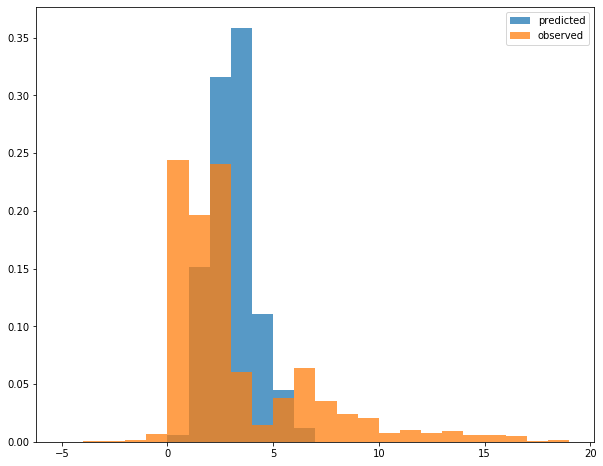

In [58]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(y_pred_test), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

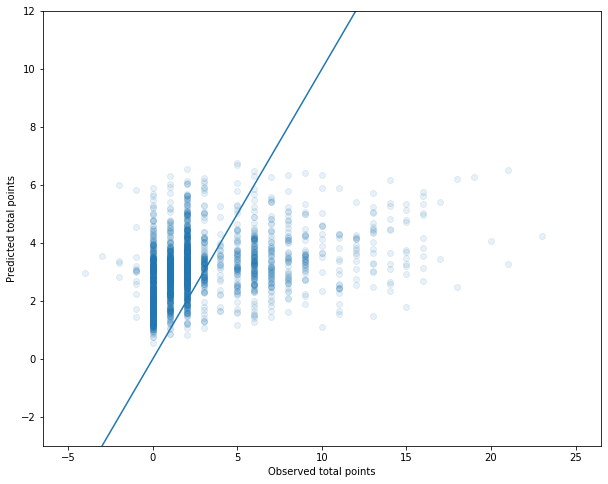

In [59]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(y_pred_test), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Summary

In [60]:
print('test loss')
pd.DataFrame([
    ('XGBoost', test_loss[0], test_loss[1], test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

test loss


,model,MAE,MSE,r2
0,XGBoost,2.48446,10.837983,0.105315


In [61]:
print('train loss')
pd.DataFrame([
    ('XGBoost', train_loss[0], train_loss[1], train_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

train loss


,model,MAE,MSE,r2
0,XGBoost,2.412876,10.052108,0.1501
